In [2]:
import dicom
import matplotlib.pyplot as plt
%matplotlib inline
from pathlib import Path
import tensorflow as tf
import numpy as np
from tqdm import tqdm_notebook
import scipy.misc
from skimage import io
import scipy.stats
import seaborn as sns
import skimage.color
from skimage.filters import threshold_otsu
import keras

from matplotlib import animation
from IPython.display import HTML
from PIL import Image
import pandas as pd
import nibabel as nib
from nibabel.testing import data_path

[[[-- -- -- ..., -- -- --]
  [-- -- -- ..., -- -- --]
  [-- -- -- ..., -- -- --]
  ..., 
  [-- -- -- ..., -- -- --]
  [-- -- -- ..., -- -- --]
  [-- -- -- ..., -- -- --]]

 [[-- -- -- ..., -- -- --]
  [-- -- -- ..., -- -- --]
  [-- -- -- ..., -- -- --]
  ..., 
  [-- -- -- ..., -- -- --]
  [-- -- -- ..., -- -- --]
  [-- -- -- ..., -- -- --]]

 [[-- -- -- ..., -- -- --]
  [-- -- -- ..., -- -- --]
  [-- -- -- ..., -- -- --]
  ..., 
  [-- -- -- ..., -- -- --]
  [-- -- -- ..., -- -- --]
  [-- -- -- ..., -- -- --]]

 ..., 
 [[-- -- -- ..., -- -- --]
  [-- -- -- ..., -- -- --]
  [-- -- -- ..., -- -- --]
  ..., 
  [-- -- -- ..., -- -- --]
  [-- -- -- ..., -- -- --]
  [-- -- -- ..., -- -- --]]

 [[-- -- -- ..., -- -- --]
  [-- -- -- ..., -- -- --]
  [-- -- -- ..., -- -- --]
  ..., 
  [-- -- -- ..., -- -- --]
  [-- -- -- ..., -- -- --]
  [-- -- -- ..., -- -- --]]

 [[-- -- -- ..., -- -- --]
  [-- -- -- ..., -- -- --]
  [-- -- -- ..., -- -- --]
  ..., 
  [-- -- -- ..., -- -- --]
  [-- -- -- ..., 

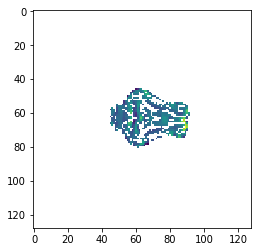

In [3]:
realigned_atlas = nib.load('../../Data/big_atlas/coregistered_pig_2_atlas.nii').get_data()
#original_atlas = nib.load('../../Data/big_atlas/atlas.nii').get_data()
anatomical = nib.load('../../Data/pig_2/coregistered_anatomy.nii').get_data()
mean_fmri = nib.load('../../Data/pig_2/rfmri nii/meanus822-0016-00001-000001-01.nii').get_data()  

mask_roi_1 = np.ma.masked_where(np.isin(realigned_atlas, [0]), realigned_atlas)
fmri_masked_roi = np.ma.masked_where(np.ma.getmask(mask_roi_1), mean_fmri) 
print(fmri_masked_roi)
plt.imshow(fmri_masked_roi[:,:,10])

In [4]:
# let's try loading the entire thing to ram
# the big tensor will have dimension [time, height, width, depth]

im = mean_fmri
all_data = np.zeros((300, im.shape[0], im.shape[1], im.shape[2]))
masked_data = np.ma.zeros((300, im.shape[0], im.shape[1], im.shape[2]))

dicom_files = [x for x in Path('../../Data/pig_2/rfmri files/').iterdir() if x.is_file() and not 'ds_store' in str(x).lower()]
dicom_files.sort(key=str)
time_index = 0
mask_roi_1 = np.ma.masked_where(np.isin(realigned_atlas, [0]), realigned_atlas)

for f in tqdm_notebook(dicom_files):
    time_file = nib.load(str(f)).get_data()
    fmri_masked_roi = np.ma.masked_where(np.ma.getmask(mask_roi_1), time_file) 
    try:
        masked_data[time_index, ...] = fmri_masked_roi
        all_data[time_index, ...] = time_file
        time_index += 1
    except:
        print(f)

In [5]:
assert all_data.shape == (300, 128, 128, 20) #300 time samples, 128x128 image, over 20 slices in z-index
assert masked_data.shape == (300, 128, 128, 20) # basic sanity check

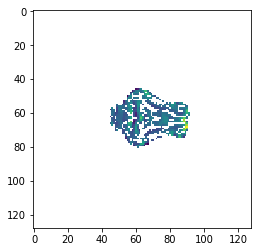

In [6]:
plt.imshow(masked_data[1,:,:,10]) # Mask is generated from an atlas, atlas disregards certain subcortical regions that are just "grey matter"

In [7]:
indices = masked_data[1,:,:,:].nonzero()
df_index = pd.MultiIndex.from_tuples(list(zip(*indices)), names=['row', 'col', 'depth'])
series_df = pd.Series(index=df_index, dtype=object)

for i, triple in tqdm_notebook(enumerate(zip(*indices)), total=len(indices[0])):
    x, y, z = triple
    trace = all_data[:, x, y, z]
    
    series_df.loc[triple] = trace

data_block = np.vstack(series_df.values)[..., np.newaxis]



In [36]:
def model():
    from keras.layers.convolutional import Conv1D, UpSampling1D
    from keras.layers.pooling import MaxPooling1D
    from keras.layers.core import Dense, Activation
    from keras.layers.normalization import BatchNormalization
    
    model = keras.models.Sequential()
    
    # padding is unspecified in paper, but maybe should be causal
    
    
    # encoder
    model.add(Conv1D(256, 3, padding='same', input_shape=[300, 1]))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling1D())
    
    model.add(Conv1D(128, 5, padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling1D())
    
    model.add(Conv1D(64, 5, padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling1D(pool_size=3))
    
    model.add(Conv1D(32, 4, padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling1D(pool_size=5))
    

    # decoder
    model.add(Conv1D(32, 4, padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(UpSampling1D(size=5))
    
    model.add(Conv1D(64, 5, padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(UpSampling1D(size=3))
    
    model.add(Conv1D(128, 5, padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(UpSampling1D())
    
    model.add(Conv1D(256, 3, padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(UpSampling1D())
    
    model.add(Conv1D(1, 1, padding='causal'))
    model.add(Activation('linear'))
    
    # section 2.1 mentions a special regularization, but I don't think that is going to work
    # the feature map in the compressed representation and the output will not be timeshuffled if we use causal conv
    
    return model


m = model()

from keras.callbacks import LearningRateScheduler
import math

# learning rate schedule
def step_decay(epoch):
	initial_lrate = 0.01
	drop = 0.5
	epochs_drop = 10.0
	lrate = initial_lrate * drop**(np.floor((1+epoch)/epochs_drop))
	return lrate

lrate = LearningRateScheduler(step_decay)
callbacks_list = []

# no optimizer specified, but let's use rmsprop
from keras import optimizers

opt = optimizers.RMSprop(lr=0.01)
m.compile(optimizer='adadelta', loss='mse')



In [37]:
shuffled_data = np.copy(data_block)
np.random.shuffle(shuffled_data)

testing_set = shuffled_data[:700]  #hold back 700 for validation
training_set = shuffled_data[700:]

print(testing_set.shape)
print(training_set.shape)
print('are you sure you want to start training')
are_you_sure = input()

if are_you_sure.lower() != 'yes':
    raise Exception()

m.fit(training_set, training_set, validation_split=0.1, epochs=50, batch_size=32, callbacks=callbacks_list)


(700, 300, 1)
(6455, 300, 1)
are you sure you want to start training
yes
Train on 5809 samples, validate on 646 samples
Epoch 1/50
5809/5809 [==============================] - 102s - loss: 3349910.5112 - val_loss: 3173669.2841
Epoch 2/50
5809/5809 [==============================] - 100s - loss: 2045359.3547 - val_loss: 334360.7625
Epoch 3/50
5809/5809 [==============================] - 98s - loss: 50017.1347 - val_loss: 16618.3021
Epoch 4/50
5809/5809 [==============================] - 97s - loss: 22256.6079 - val_loss: 11789.7808
Epoch 5/50
5809/5809 [==============================] - 97s - loss: 18834.9158 - val_loss: 14998.8259
Epoch 6/50
5809/5809 [==============================] - 97s - loss: 16922.5889 - val_loss: 8902.2392
Epoch 7/50
5809/5809 [==============================] - 104s - loss: 17078.4329 - val_loss: 9597.1544
Epoch 8/50
5809/5809 [==============================] - 110s - loss: 14116.3257 - val_loss: 8930.9742
Epoch 9/50
5809/5809 [==============================] - 

In [34]:
m.evaluate(testing_set, testing_set)


700/700 [==============================] - 2s     


11963.541981026785

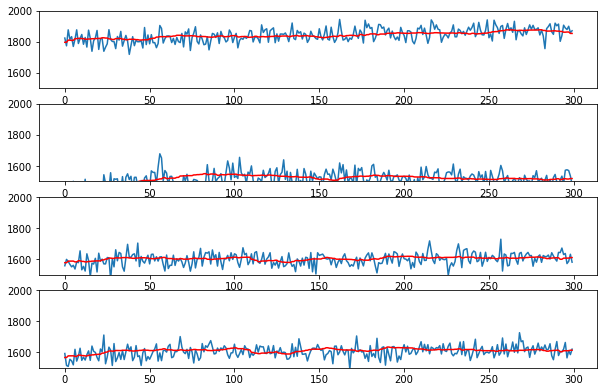

In [56]:
from keras import backend as K
from keras.models import load_model

sample_1 = data_block[np.newaxis, 6000]
output_1 = m.predict(sample_1)

sample_2 = data_block[np.newaxis, 6001]
output_2 = m.predict(sample_2)

sample_3 = data_block[np.newaxis, 6002]
output_3 = m.predict(sample_3)

sample_4 = data_block[np.newaxis, 6003]
output_4 = m.predict(sample_4)


plt.figure(figsize=(10, 10))
plt.subplot(611)
plt.ylim((1500,2000))
plt.plot(np.squeeze(sample_1))
plt.plot(np.squeeze(output_1), c='r')
plt.subplot(612)
plt.ylim((1500,2000))
plt.plot(np.squeeze(sample_2))
plt.plot(np.squeeze(output_2), c='r')
plt.subplot(613)
plt.ylim((1500,2000))
plt.plot(np.squeeze(sample_3))
plt.plot(np.squeeze(output_3), c='r')
plt.subplot(614)
plt.ylim((1500,2000))
plt.plot(np.squeeze(sample_4))
plt.plot(np.squeeze(output_4), c='r')


In [23]:
m.save('model_e11g.h5')

In [44]:
m.layers[15].get_config()

{'name': 'max_pooling1d_21',
 'padding': 'valid',
 'pool_size': (5,),
 'strides': (5,),
 'trainable': True}

In [46]:
embedding_model = keras.models.Model(inputs=m.input,
                                 outputs=m.layers[15].output)
embeddings = embedding_model.predict(data_block)
squished_embeddings = np.reshape(embeddings, (embeddings.shape[0], -1))

print(embeddings.shape)
print(squished_embeddings.shape)

np.save('../../Data/numpy-data/e11g-embeddings-squished.npy', squished_embeddings)

(7155, 5, 32)
(7155, 160)
